In [ ]:
# 0. Install + Imports (PyTorch, Torchvision, etc.)

# We'll start by bringing in all the necessary libraries for our project.
# Think of these as our toolbox for image processing, deep learning, and plotting.
import os
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
###############################################
# 1. CONFIGURATION
###############################################

# Here, we set up some important variables for our project.
# If you're running this locally, you might need to adjust this path.
DATASET_DIR = Path("brain_tumor_dataset")


# We need a way to map our folder names ('no', 'yes') to numbers (0, 1)
# and vice-versa. This makes it easier for our model to understand.
CLASS_TO_IDX = {"no": 0, "yes": 1}
IDX_TO_CLASS = {v: k for k, v in CLASS_TO_IDX.items()}

# Setting a 'seed' helps ensure that our results are reproducible.
# If you run the code again, you should get the same random splits and model initialization.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Just a quick check to make sure our dataset folder is where we expect it to be,
# and to see the subfolders (which are our classes).
print("Dataset directory exists:", DATASET_DIR.exists())
print("Subfolders:", [p.name for p in DATASET_DIR.iterdir() if p.is_dir()])

Dataset directory exists: True
Subfolders: ['yes', 'no']


Class 'no' -> found 86 images
Class 'yes' -> found 87 images

Total images in dataset: 173
Class distribution: {'no': np.int64(86), 'yes': np.int64(87)}


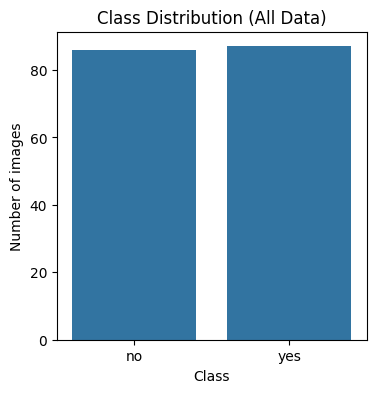

In [ ]:
# Let's explore our dataset a bit to see what we're working with!
# We'll scan through all the image files and get some basic statistics.

all_paths = []
all_labels = []

# We'll go through each of our class folders (like 'no' and 'yes' tumor images)
for class_name, label in CLASS_TO_IDX.items():
    class_dir = DATASET_DIR / class_name
    # Just a quick check to make sure the folder actually exists
    if not class_dir.exists():
        print(f"WARNING: folder {class_dir} not found!")
        continue

    # Collect all image files – both .jpg and .png, just to be safe!
    image_files = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
    print(f"Class '{class_name}' -> found {len(image_files)} images")

    # Store the path and its corresponding label for each image
    for img_path in image_files:
        all_paths.append(img_path)
        all_labels.append(label)

# Convert our lists to numpy arrays for easier handling
all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

print("\nTotal images in dataset:", len(all_paths))

# ---- Let's look at the class distribution to see if it's balanced ----
unique, counts = np.unique(all_labels, return_counts=True)
class_counts = {IDX_TO_CLASS[u]: c for u, c in zip(unique, counts)}
print("Class distribution:", class_counts)

# And a nice bar plot to visualize those class counts!
plt.figure(figsize=(4, 4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution (All Data)")
plt.ylabel("Number of images")
plt.xlabel("Class")
plt.show()

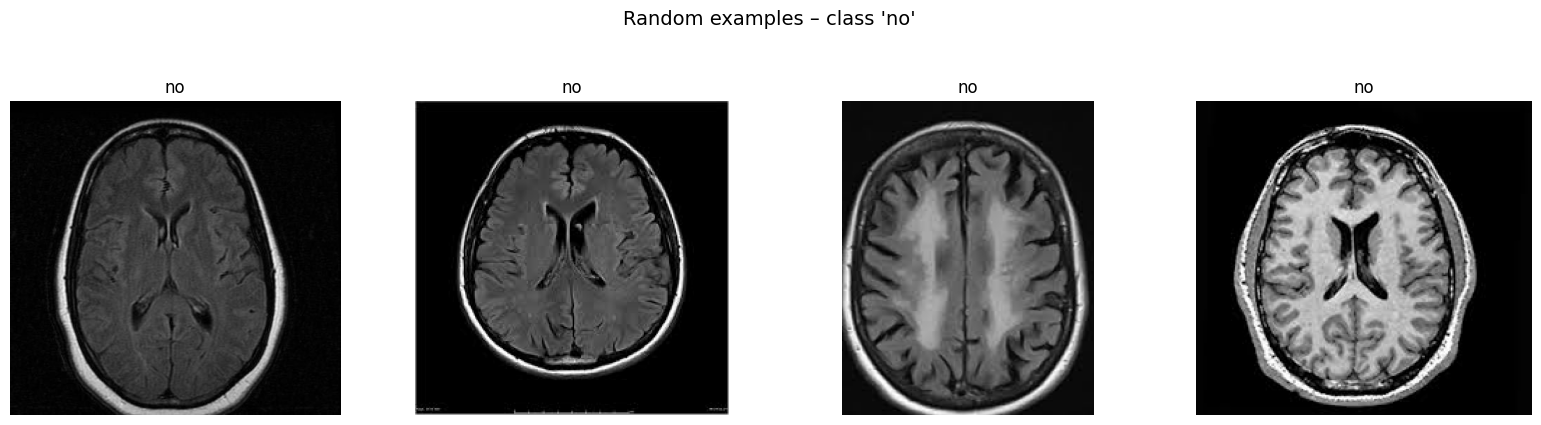

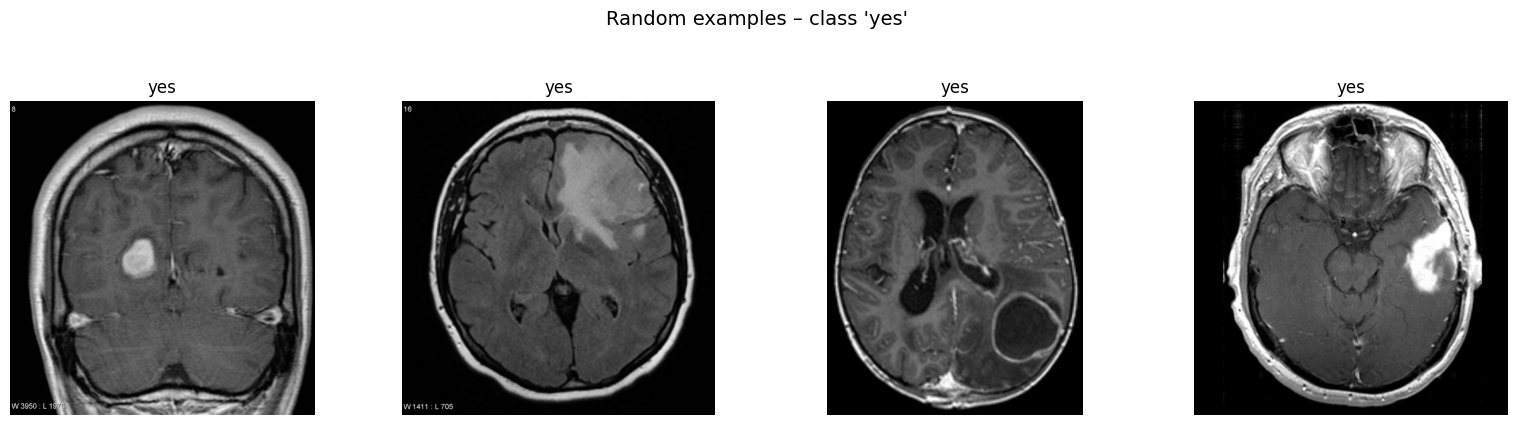

In [ ]:
###############################################
# 2.1 EDA – VISUALIZE SAMPLE IMAGES PER CLASS
###############################################

def show_random_examples(class_name, n=4):
    """
    Let's pick a few random images from a given class to get a quick visual feel for the data.
    """
    class_dir = DATASET_DIR / class_name
    image_files = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
    n = min(n, len(image_files))

    if n == 0:
        print(f"No images found for class {class_name}")
        return

    sample_files = random.sample(image_files, n)

    plt.figure(figsize=(4 * n, 4))
    for i, img_path in enumerate(sample_files):
        img = Image.open(img_path).convert("RGB")
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"{class_name}")
        plt.axis("off")
    plt.suptitle(f"Random examples – class '{class_name}'", y=1.05, fontsize=14)
    plt.tight_layout()
    plt.show()

# Let's see some examples from both 'no' and 'yes' classes!
show_random_examples("no", n=4)
show_random_examples("yes", n=4)

Checked 173 images for size stats.
Height: min=168, max=1427, mean=407.7
Width : min=150, max=1920, mean=383.7


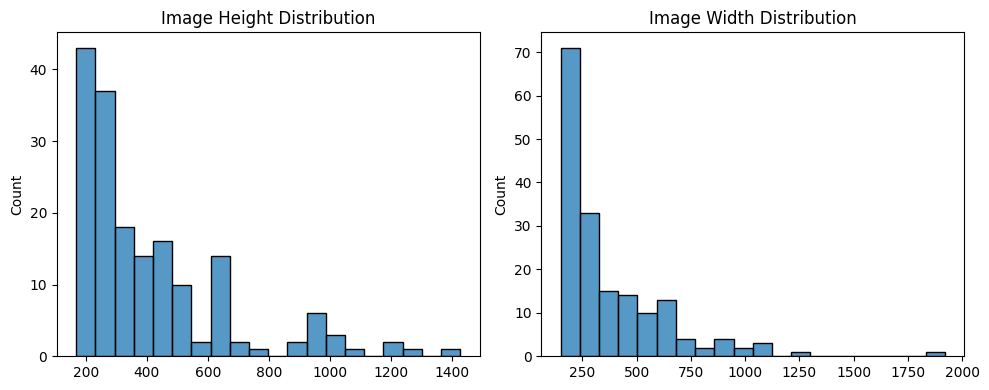

In [ ]:
###############################################
# 2.2 EDA – IMAGE SIZE DISTRIBUTION
###############################################
# It's a good idea to check if our images are all roughly the same size.
# This helps us understand what kind of resizing we might need to do later.

heights = []
widths = []

# We'll loop through a subset of images (or all of them) to gather size info.
# You can change MAX_IMAGES_FOR_SIZE if you have a huge dataset and want to speed this up.
MAX_IMAGES_FOR_SIZE = 300

for i, img_path in enumerate(all_paths):
    if i >= MAX_IMAGES_FOR_SIZE:
        break
    img = Image.open(img_path)
    w, h = img.size  # PIL gives us (width, height)
    widths.append(w)
    heights.append(h)

heights = np.array(heights)
widths = np.array(widths)

print(f"We checked {len(heights)} images for their size stats.")
print(f"Image Heights: min={heights.min()}, max={heights.max()}, mean={heights.mean():.1f}")
print(f"Image Widths : min={widths.min()}, max={widths.max()}, mean={widths.mean():.1f}")

# Now, let's visualize these distributions with histograms!
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(heights, bins=20, kde=False)
plt.title("Distribution of Image Heights")

plt.subplot(1, 2, 2)
sns.histplot(widths, bins=20, kde=False)
plt.title("Distribution of Image Widths")

plt.tight_layout()
plt.show()

In [ ]:
###############################################
# 3. STRATIFIED TRAIN/VAL/TEST SPLITS
###############################################

# We need to split our data into three groups: for training, validation, and testing.
# This helps us train our model, tune it, and then evaluate its final performance.

# Let's decide how much data goes into our test and validation sets.
TEST_SIZE = 0.15   # 15% of all data will be for final testing
VAL_SIZE = 0.15    # 15% will be for validation during training

# 1) First, we'll split off a portion for training and a temporary combined validation/test set.
# We use 'stratify=all_labels' to make sure each split has a similar proportion of 'no' and 'yes' images.
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths,
    all_labels,
    test_size=TEST_SIZE + VAL_SIZE,   # This is the total part for val+test
    stratify=all_labels,              # Keep the class distribution balanced!
    random_state=SEED,                # Ensure we get the same split every time
)

# 2) Now, we'll take that temporary set and split it further into our actual validation and test sets.
# The 'val_relative_size' ensures the proportions are correct.
val_relative_size = VAL_SIZE / (TEST_SIZE + VAL_SIZE)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=1 - val_relative_size,  # This makes sure our val:test ratio is what we want
    stratify=temp_labels,
    random_state=SEED,
)

# Let's quickly print out the sizes of our new datasets to confirm the split.
print(f"Train size: {len(train_paths)}")
print(f"Val   size: {len(val_paths)}")
print(f"Test  size: {len(test_paths)}")

# This little helper function just prints the breakdown of classes in each split.
def print_split_distribution(name, labels):
    unique, counts = np.unique(labels, return_counts=True)
    dist = {IDX_TO_CLASS[u]: c for u, c in zip(unique, counts)}
    print(f"{name} class distribution:", dist)

print_split_distribution("Train", train_labels)
print_split_distribution("Val",   val_labels)
print_split_distribution("Test",  test_labels)

Train size: 121
Val   size: 26
Test  size: 26
Train class distribution: {'no': np.int64(60), 'yes': np.int64(61)}
Val class distribution: {'no': np.int64(13), 'yes': np.int64(13)}
Test class distribution: {'no': np.int64(13), 'yes': np.int64(13)}


In [ ]:
###############################################
# 4. TRANSFORMS & DATASET CLASS
###############################################

# These are important PyTorch components for handling our image data.
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch

# Our model (EfficientNet) expects images to be a specific size.
# This is a common size for many research models.
IMG_SIZE = 224

# For training, we'll apply some 'data augmentation'. This means slightly
# modifying the images (flipping, rotating, etc.) to make our model more robust.
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),          # Make all images the same size
    transforms.RandomHorizontalFlip(p=0.5),          # Randomly flip images horizontally
    transforms.RandomRotation(degrees=15),           # Randomly rotate images a bit
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)), # Randomly crop and resize
    transforms.ColorJitter(brightness=0.15, contrast=0.15),   # Randomly change brightness/contrast
    transforms.ToTensor(),                           # Convert image to a PyTorch tensor
    transforms.Normalize(                            # Standardize pixel values (ImageNet stats)
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

# For validation and testing, we don't want any random changes.
# We just resize and normalize the images.
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),          # Make all images the same size
    transforms.ToTensor(),                           # Convert to tensor
    transforms.Normalize(                            # Standardize pixel values
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])


class BrainMRIDataset(Dataset):
    """
    This is our custom dataset class.
    It tells PyTorch how to load individual images and their labels.
    It will output (image_tensor, label_integer).
    """
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = list(img_paths)
        self.labels = list(labels)
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]

        # Open the image and make sure it's in RGB format (some might be grayscale).
        img = Image.open(img_path).convert("RGB")

        # Apply any transformations we defined (like resizing, augmentation, normalization).
        if self.transform is not None:
            img = self.transform(img)

        return img, label


Train batches per epoch: 4


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


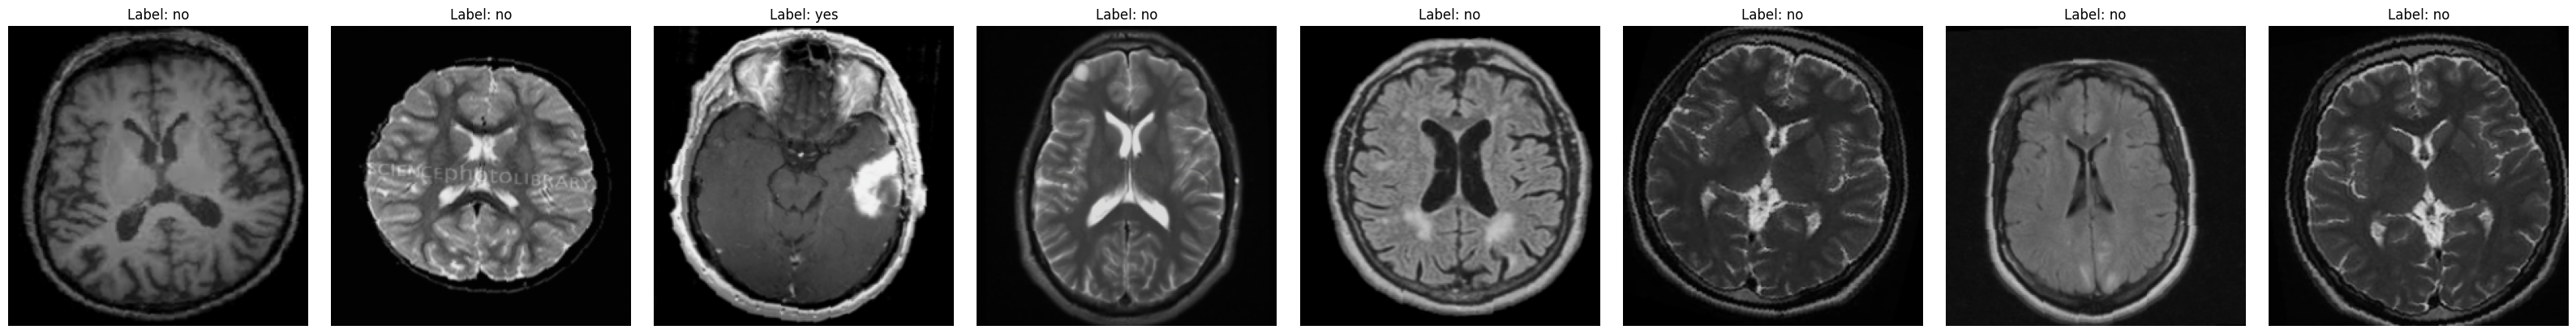

In [ ]:
###############################################
# 5. DATALOADERS & SAMPLE VISUALIZATION
###############################################

# Setting our batch size and number of workers for loading data
BATCH_SIZE = 32
NUM_WORKERS = 2  # Increase this if you have a powerful CPU to load data faster!

# Creating our dataset objects for training, validation, and testing
train_dataset = BrainMRIDataset(train_paths, train_labels, transform=train_transform)
val_dataset   = BrainMRIDataset(val_paths,   val_labels,   transform=val_test_transform)
test_dataset  = BrainMRIDataset(test_paths,  test_labels,  transform=val_test_transform)

# And now, the DataLoaders! These will efficiently feed data to our model.
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
)

print("Number of training batches per epoch:", len(train_loader))


# ---- Let's visualize some augmented training images to see what the model sees! ----
def show_batch(dataloader, n_images=8):
    # Grab one batch of images and their labels
    imgs, labels = next(iter(dataloader))
    imgs = imgs[:n_images]
    labels = labels[:n_images]

    # We need to "undo" the normalization we applied earlier so the images look correct when displayed
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    imgs_unnorm = imgs * std + mean

    plt.figure(figsize=(4 * n_images, 4))
    for i in range(n_images):
        ax = plt.subplot(1, n_images, i + 1)
        img_np = imgs_unnorm[i].permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1) # Just in case values are slightly out of 0-1 range
        label = labels[i].item()
        plt.imshow(img_np)
        plt.title(f"Label: {IDX_TO_CLASS[label]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Display a batch of our training images with augmentation applied!
show_batch(train_loader)

In [ ]:
###############################################
# 6. BUILD TRANSFER-LEARNING MODEL (EfficientNet-B0)
###############################################

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Load pre-trained EfficientNet-B0 (ImageNet)
# We're using a model that's already learned a lot from a huge image dataset!
base_model = models.efficientnet_b0(
    weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
)

# Freeze feature layers initially
# For now, we'll keep the powerful 'feature extraction' part of the model frozen.
# This means it won't change during our initial training, saving time and preventing overfitting.
for param in base_model.features.parameters():
    param.requires_grad = False

# Replace classifier head
# We'll swap out the original 'brain' of the model (its final layers) with a new, simpler one.
# This new head will learn to classify *our specific* brain MRI images.
in_features = base_model.classifier[1].in_features
base_model.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True), # A bit of dropout to help prevent overfitting
    nn.Linear(in_features, 1)  # Just one output neuron for our binary (yes/no) classification
)

model = base_model.to(DEVICE) # Move the whole model to our chosen device (GPU or CPU)
print(model)


Using device: cpu
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 37.0MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
###############################################
# 7. LOSS, OPTIMIZER, SCHEDULER, METRIC
###############################################

# We're using Binary Cross-Entropy with Logits – it's super stable for binary classification
criterion = nn.BCEWithLogitsLoss()

# We'll use the Adam optimizer, and for now, we're only optimizing
# the parameters in the classifier head (since we froze the base model).
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

# How many times we'll go through the entire training dataset
EPOCHS = 20

# Cosine Annealing is a fancy way to adjust our learning rate during training.
# It helps the model converge smoothly!
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS
)

# A helper function to calculate accuracy from the model's raw outputs (logits)
def accuracy_from_logits(logits, labels):
    """
    This little function takes our model's raw predictions (logits) and the true labels,
    then tells us how accurate it was. It converts logits into probabilities and then
    into class predictions (0 or 1).

    Args:
        logits: The model's raw output before the sigmoid activation.
        labels: The actual true labels for comparison.
    """
    # Convert logits to probabilities (between 0 and 1)
    probs = torch.sigmoid(logits)
    # Turn probabilities into hard predictions (0 or 1) based on a 0.5 threshold
    preds = (probs >= 0.5).long().view(-1)
    labels = labels.view(-1).long()
    # Count how many predictions were correct
    correct = (preds == labels).float().sum()
    # Return the accuracy as a percentage (well, a fraction in [0,1])
    return (correct / len(labels)).item()

In [ ]:
###############################################
# 8. TRAIN & VALIDATE LOOP (Improved Version)
###############################################

best_val_acc = 0.0
best_model_path = "best_model_state_dict.pth"
best_model_full_path = "best_model_full.pth"

train_history = {"loss": [], "acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    print("-" * 40)

    # -------------------------
    # TRAINING PHASE
    # -------------------------
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    n_train_batches = 0

    for images, labels in train_loader:
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.float().to(DEVICE, non_blocking=True)

        optimizer.zero_grad()

        logits = model(images).view(-1)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy_from_logits(logits.detach(), labels.detach())
        n_train_batches += 1

    train_loss /= n_train_batches
    train_acc /= n_train_batches

    # -------------------------
    # VALIDATION PHASE
    # -------------------------
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    n_val_batches = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.float().to(DEVICE, non_blocking=True)

            logits = model(images).view(-1)
            loss = criterion(logits, labels)

            val_loss += loss.item()
            val_acc += accuracy_from_logits(logits, labels)
            n_val_batches += 1

    val_loss /= n_val_batches
    val_acc /= n_val_batches

    # Scheduler step
    scheduler.step()

    # Save training history
    train_history["loss"].append(train_loss)
    train_history["acc"].append(train_acc)
    train_history["val_loss"].append(val_loss)
    train_history["val_acc"].append(val_acc)

    # Print results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # -------------------------
    # SAVE BEST MODEL
    # -------------------------
    if val_acc > best_val_acc:
        best_val_acc = val_acc

        # Save only weights (recommended for training)
        torch.save(model.state_dict(), best_model_path)

        # Save full model (recommended for deployment)
        torch.save(model, best_model_full_path)

        print(f"💾 Saved New Best Model!")
        print(f"   → Accuracy: {best_val_acc:.4f}")
        print(f"   → Weights: {best_model_path}")
        print(f"   → Full Model: {best_model_full_path}")



Epoch 1/20
----------------------------------------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 0.5346 | Train Acc: 0.7772
Val   Loss: 0.5080 | Val   Acc: 0.8846
💾 Saved New Best Model!
   → Accuracy: 0.8846
   → Weights: best_model_state_dict.pth
   → Full Model: best_model_full.pth

Epoch 2/20
----------------------------------------
Train Loss: 0.5275 | Train Acc: 0.7738
Val   Loss: 0.5170 | Val   Acc: 0.8846

Epoch 3/20
----------------------------------------
Train Loss: 0.4931 | Train Acc: 0.8363
Val   Loss: 0.5202 | Val   Acc: 0.8462

Epoch 4/20
----------------------------------------
Train Loss: 0.5256 | Train Acc: 0.8238
Val   Loss: 0.5222 | Val   Acc: 0.8462

Epoch 5/20
----------------------------------------
Train Loss: 0.5238 | Train Acc: 0.7547
Val   Loss: 0.5170 | Val   Acc: 0.8462

Epoch 6/20
----------------------------------------
Train Loss: 0.5318 | Train Acc: 0.7837
Val   Loss: 0.5109 | Val   Acc: 0.8462

Epoch 7/20
----------------------------------------
Train Loss: 0.5203 | Train Acc: 0.8150
Val   Loss: 0.5010 | Val   Acc: 0.8462

Epoch 8/20
-

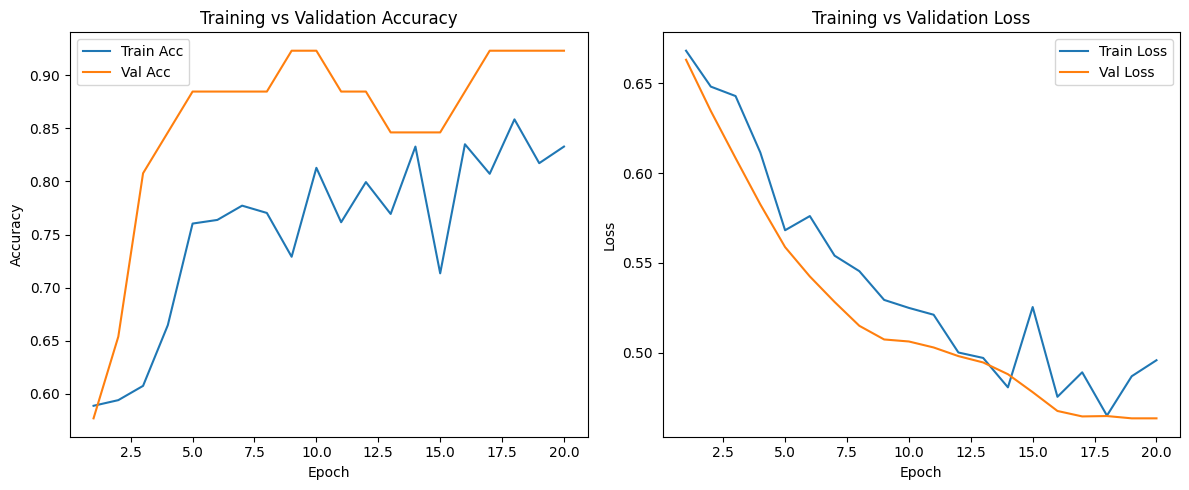

In [ ]:
###############################################
# 9. PLOT TRAINING HISTORY
###############################################

# Let's visualize how our model performed during training!
# These plots help us see if it's learning well and if we're overfitting.
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# First plot: Accuracy over time
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_history["acc"], label="Train Acc")
plt.plot(epochs_range, train_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Second plot: Loss over time
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_history["loss"], label="Train Loss")
plt.plot(epochs_range, train_history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.tight_layout() # Makes sure plots don't overlap
plt.show() # Show the beautiful plots!

Classification report (test):
              precision    recall  f1-score   support

      no (0)       0.90      0.69      0.78        13
     yes (1)       0.75      0.92      0.83        13

    accuracy                           0.81        26
   macro avg       0.82      0.81      0.81        26
weighted avg       0.83      0.81      0.81        26



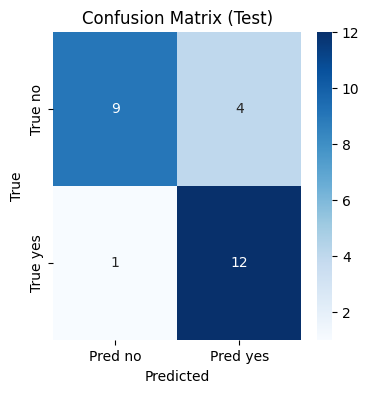

In [ ]:
###############################################
# 9. TEST SET EVALUATION
###############################################

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Time to see how our BEST model really performs on completely new, unseen data!

# Load the best model weights we saved during training
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
model.eval() # Set the model to evaluation mode

all_true = [] # To store the actual labels
all_pred = [] # To store the model's predictions

with torch.no_grad(): # We don't need to calculate gradients for evaluation
    for images, labels in test_loader:
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        logits = model(images).view(-1) # Get the raw outputs
        probs = torch.sigmoid(logits)   # Convert to probabilities
        preds = (probs >= 0.5).long()   # Turn probabilities into 0s or 1s

        all_true.extend(labels.cpu().numpy().tolist())
        all_pred.extend(preds.cpu().numpy().tolist())

all_true = np.array(all_true)
all_pred = np.array(all_pred)

print("Classification report (test):")
print(classification_report(
    all_true, all_pred,
    target_names=[f"no ({CLASS_TO_IDX['no']})", f"yes ({CLASS_TO_IDX['yes']})"]
))

# Let's visualize the Confusion Matrix – it's a great way to see
# how many times our model was right and wrong for each class.
cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Pred no", "Pred yes"],
    yticklabels=["True no", "True yes"]
)
plt.title("Confusion Matrix (Test)")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


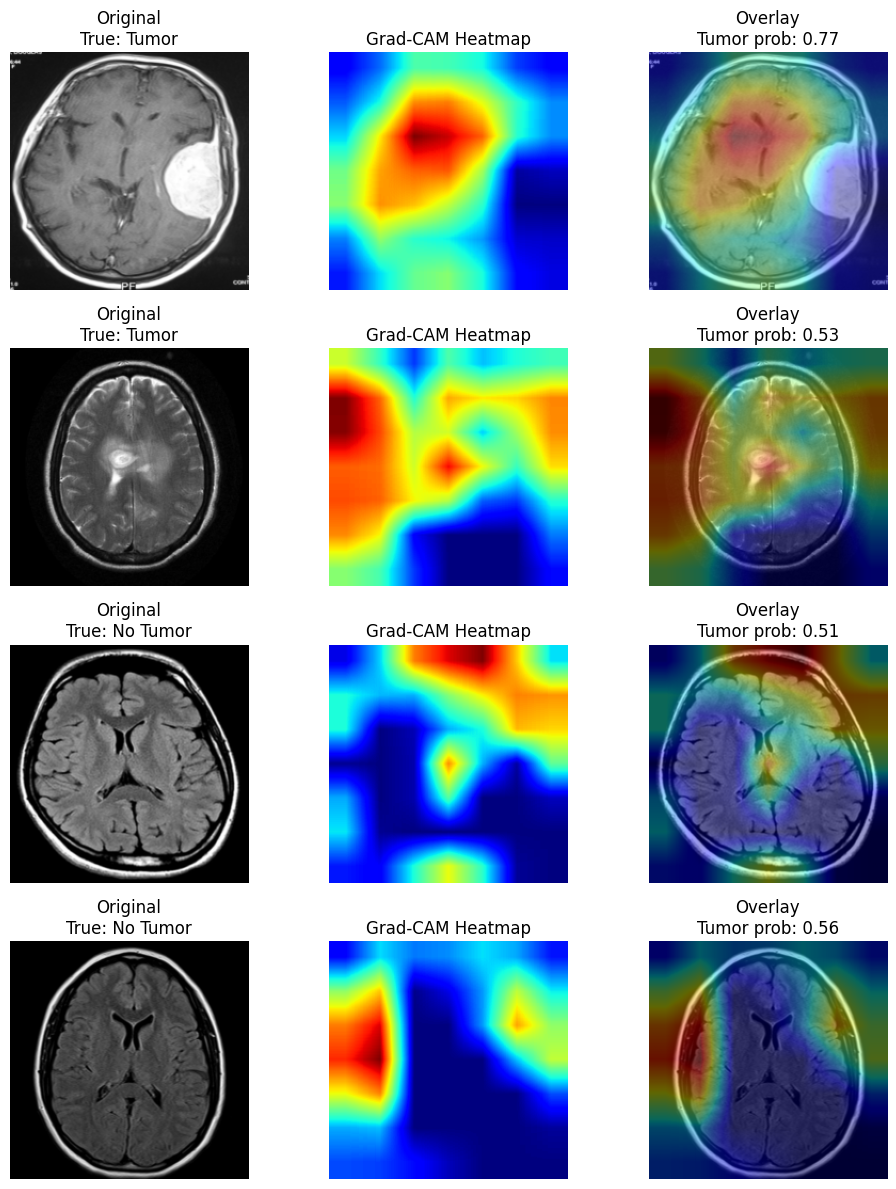

In [ ]:
###############################################
# 10. GRAD-CAM VISUALIZATION - Let's see what the model is looking at!
###############################################

# We need to target a specific layer to see its activations and gradients.
# For EfficientNet-B0, the last convolutional layer in its 'features' part is usually a good choice.
last_conv_layer = model.features[-1][0]  # This is essentially the heart of the feature extraction

# This global variable will temporarily hold the activations of our chosen layer.
# It's important to make sure we retain its gradients for Grad-CAM to work!
conv_activations_retained = None

def save_activation_and_retain_grad(module, input, output):
    global conv_activations_retained
    # Just making sure the output tensor is set up to record gradients
    if not output.requires_grad:
        output.requires_grad_(True)
    # This is the magic step! We tell PyTorch to hold onto the gradients for this specific output.
    # It's super important, especially if some parts of the model are 'frozen'.
    output.retain_grad()
    conv_activations_retained = output

# We're registering a 'forward hook' here. Think of it like a little observer
# that kicks in every time data passes through our `last_conv_layer`.
# If we run this cell multiple times, we want to avoid registering the hook over and over,
# so we check if there's an old one and remove it first.

# Clean up any old hooks if they exist from previous runs
if 'hook_handle_gradcam' in globals() and hook_handle_gradcam is not None:
    hook_handle_gradcam.remove()

hook_handle_gradcam = last_conv_layer.register_forward_hook(save_activation_and_retain_grad)


def compute_gradcam(image_tensor):
    """
    This function calculates the Grad-CAM heatmap for a given image.
    It essentially shows us which parts of the image were most important
    for the model's prediction.

    Args:
        image_tensor: A single image tensor (1, 3, H, W) that's already normalized.

    Returns:
        heatmap: A numpy array (H, W) with values from 0 to 1, showing importance.
        prob_tumor: The model's predicted probability that the image contains a tumor.
    """
    model.eval() # Always set the model to evaluation mode for consistent predictions
    image_tensor = image_tensor.to(DEVICE)

    # Let's clear our global activations storage for each new image
    global conv_activations_retained
    conv_activations_retained = None

    # First, a forward pass to get the model's prediction (logits) and store activations
    logits = model(image_tensor).view(-1)  # Get the raw output, shape (1,)
    prob_tumor = torch.sigmoid(logits)[0] # Convert logits to a probability between 0 and 1

    # Now for the 'backward' part – we're calculating gradients with respect to the tumor probability
    model.zero_grad() # Clear out old gradients
    prob_tumor.backward(retain_graph=True) # Backpropagate to get gradients on the activations

    # Grab the activations and their gradients, which were stored by our hook
    activations = conv_activations_retained
    gradients = activations.grad # Hooray, the gradients are right here!

    # Just a safety check in case something went wrong with the hook
    if activations is None or gradients is None:
        print("Uh oh! Activations or gradients are missing. The hook might not have worked.")
        return np.zeros((IMG_SIZE, IMG_SIZE)), float(prob_tumor.item() if prob_tumor is not None else 0.0)

    # Detach them so we don't accidentally mess up future gradient calculations
    activations = activations.detach()
    gradients = gradients.detach()

    # We're doing a Global Average Pooling on the gradients to get a 'weight' for each channel
    pooled_grads = torch.mean(gradients, dim=(2, 3))  # Result is (1, C)

    conv_activations_local = activations[0]  # Get rid of the batch dimension: (C, Hc, Wc)
    pooled_grads_local = pooled_grads[0]         # Same for pooled grads: (C,)

    # Now, we multiply each activation map by its corresponding gradient weight
    for c in range(conv_activations_local.shape[0]):
        conv_activations_local[c, :, :] *= pooled_grads_local[c]

    # Sum up all the weighted activation maps to get our raw heatmap
    heatmap = torch.sum(conv_activations_local, dim=0)

    # Apply ReLU to only keep the positive influences (gradients)
    heatmap = torch.relu(heatmap)

    # Normalize the heatmap to be between 0 and 1 for easy visualization
    heatmap_max = heatmap.max()
    if heatmap_max > 1e-8: # Avoid dividing by a tiny number or zero
        heatmap = heatmap / heatmap_max
    else:
        heatmap = heatmap * 0  # If nothing activated strongly, just make it all black

    heatmap = heatmap.cpu().numpy() # Convert to a numpy array for plotting
    return heatmap, float(prob_tumor.item())


def show_gradcam_on_test(n_images=4):
    """
    Picks a few random images from the test set, calculates Grad-CAM for them,
    and displays the results.
    """
    model.eval() # Make sure our model is in evaluation mode

    # Let's grab a batch of images and their labels from our test dataset
    for images, labels in test_loader:
        images = images[:n_images]
        labels = labels[:n_images]
        break # We only need the first few for our example

    # These are our normalization stats (used to get the image back to normal colors)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

    plt.figure(figsize=(10, 3 * n_images))

    # Loop through each image we picked
    for i in range(n_images):
        img = images[i].unsqueeze(0)  # Add a batch dimension (1,3,H,W)
        # Calculate the heatmap and the model's tumor probability for this image
        heatmap, prob_tumor = compute_gradcam(img.clone())

        # Resize the heatmap to match our original image size
        heatmap_resized = Image.fromarray((heatmap * 255).astype(np.uint8))
        heatmap_resized = heatmap_resized.resize((IMG_SIZE, IMG_SIZE), resample=Image.BILINEAR)
        heatmap_resized = np.array(heatmap_resized) / 255.0

        # Denormalize the image so it looks correct when plotted
        img_denorm = img * std + mean
        img_np = img_denorm[0].permute(1, 2, 0).cpu().numpy() # CHW to HWC for matplotlib
        img_np = np.clip(img_np, 0, 1) # Clip values to stay within 0-1 range

        # Convert our grayscale heatmap into a colorful one (using 'jet' colormap)
        import matplotlib.cm as cm
        heatmap_color = cm.jet(heatmap_resized)[..., :3]  # Drop the alpha channel

        # Overlay the heatmap onto the original image
        alpha = 0.4 # How transparent should the heatmap be?
        overlay = (1 - alpha) * img_np + alpha * heatmap_color
        overlay = np.clip(overlay, 0, 1) # Make sure colors are still valid

        # Get the true label and format it nicely for the title
        true_label = labels[i].item()
        true_txt = "Tumor" if true_label == 1 else "No Tumor"

        # Plotting time!
        plt.subplot(n_images, 3, 3 * i + 1)
        plt.imshow(img_np)
        plt.title(f"Original\nTrue: {true_txt}")
        plt.axis("off")

        plt.subplot(n_images, 3, 3 * i + 2)
        plt.imshow(heatmap_resized, cmap="jet")
        plt.title("Grad-CAM Heatmap")
        plt.axis("off")

        plt.subplot(n_images, 3, 3 * i + 3)
        plt.imshow(overlay)
        plt.title(f"Overlay\nTumor prob: {prob_tumor:.2f}")
        plt.axis("off")

    plt.tight_layout() # Adjust everything so it doesn't overlap
    plt.show() # Show off the visualizations!


# Let's see some examples!
show_gradcam_on_test(n_images=4)

In [ ]:
###############################################
# XAI: INSTALL & IMPORT PYTORCH-GRAD-CAM
###############################################

# If you're on Kaggle/Colab, run this cell once:
# This installs the library we'll use for cool explainability visualizations!
!pip install -q grad-cam

import torch
import numpy as np
import matplotlib.pyplot as plt

# Bringing in the specific Grad-CAM tools we need
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
###############################################
# XAI: CREATE CAM OBJECTS
###############################################

# We'll use the last convolutional layer of our EfficientNet-B0 model as the 'target layer'.
# This is typically where rich, high-level features are extracted before the final prediction.
target_layer = model.features[-1][0]   # This points to the final convolutional block's main layer

# Now, let's create instances of our different CAM methods.
# These objects are like tools that will generate heatmaps for us.
cam_grad    = GradCAM(model=model, target_layers=[target_layer])
cam_gradpp  = GradCAMPlusPlus(model=model, target_layers=[target_layer])
cam_score   = ScoreCAM(model=model, target_layers=[target_layer])


In [ ]:
###############################################
# XAI: VISUALIZATION HELPER
###############################################

# ImageNet mean/std used in transforms (same as training)
# These are the numbers we used to normalize our images. We'll need them to 'undo' that normalization later for plotting.
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def denormalize(tensor):
    """
    Takes a PyTorch tensor that's been normalized with ImageNet stats (our images!)
    and converts it back into a display-friendly NumPy array in the 0-1 range.
    It's essentially reversing the preprocessing for a pretty picture!

    Args:
        tensor: A (3, H, W) PyTorch tensor, typically normalized.

    Returns:
        A (H, W, 3) NumPy array with pixel values between 0 and 1.
    """
    img = tensor.cpu().numpy()
    img = img.transpose(1, 2, 0)  # Change from Channel-Height-Width to Height-Width-Channel
    img = img * IMAGENET_STD + IMAGENET_MEAN # Scale pixel values back up
    img = np.clip(img, 0, 1) # Ensure values are strictly within 0 and 1
    return img


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 80/80 [01:25<00:00,  1.06s/it]


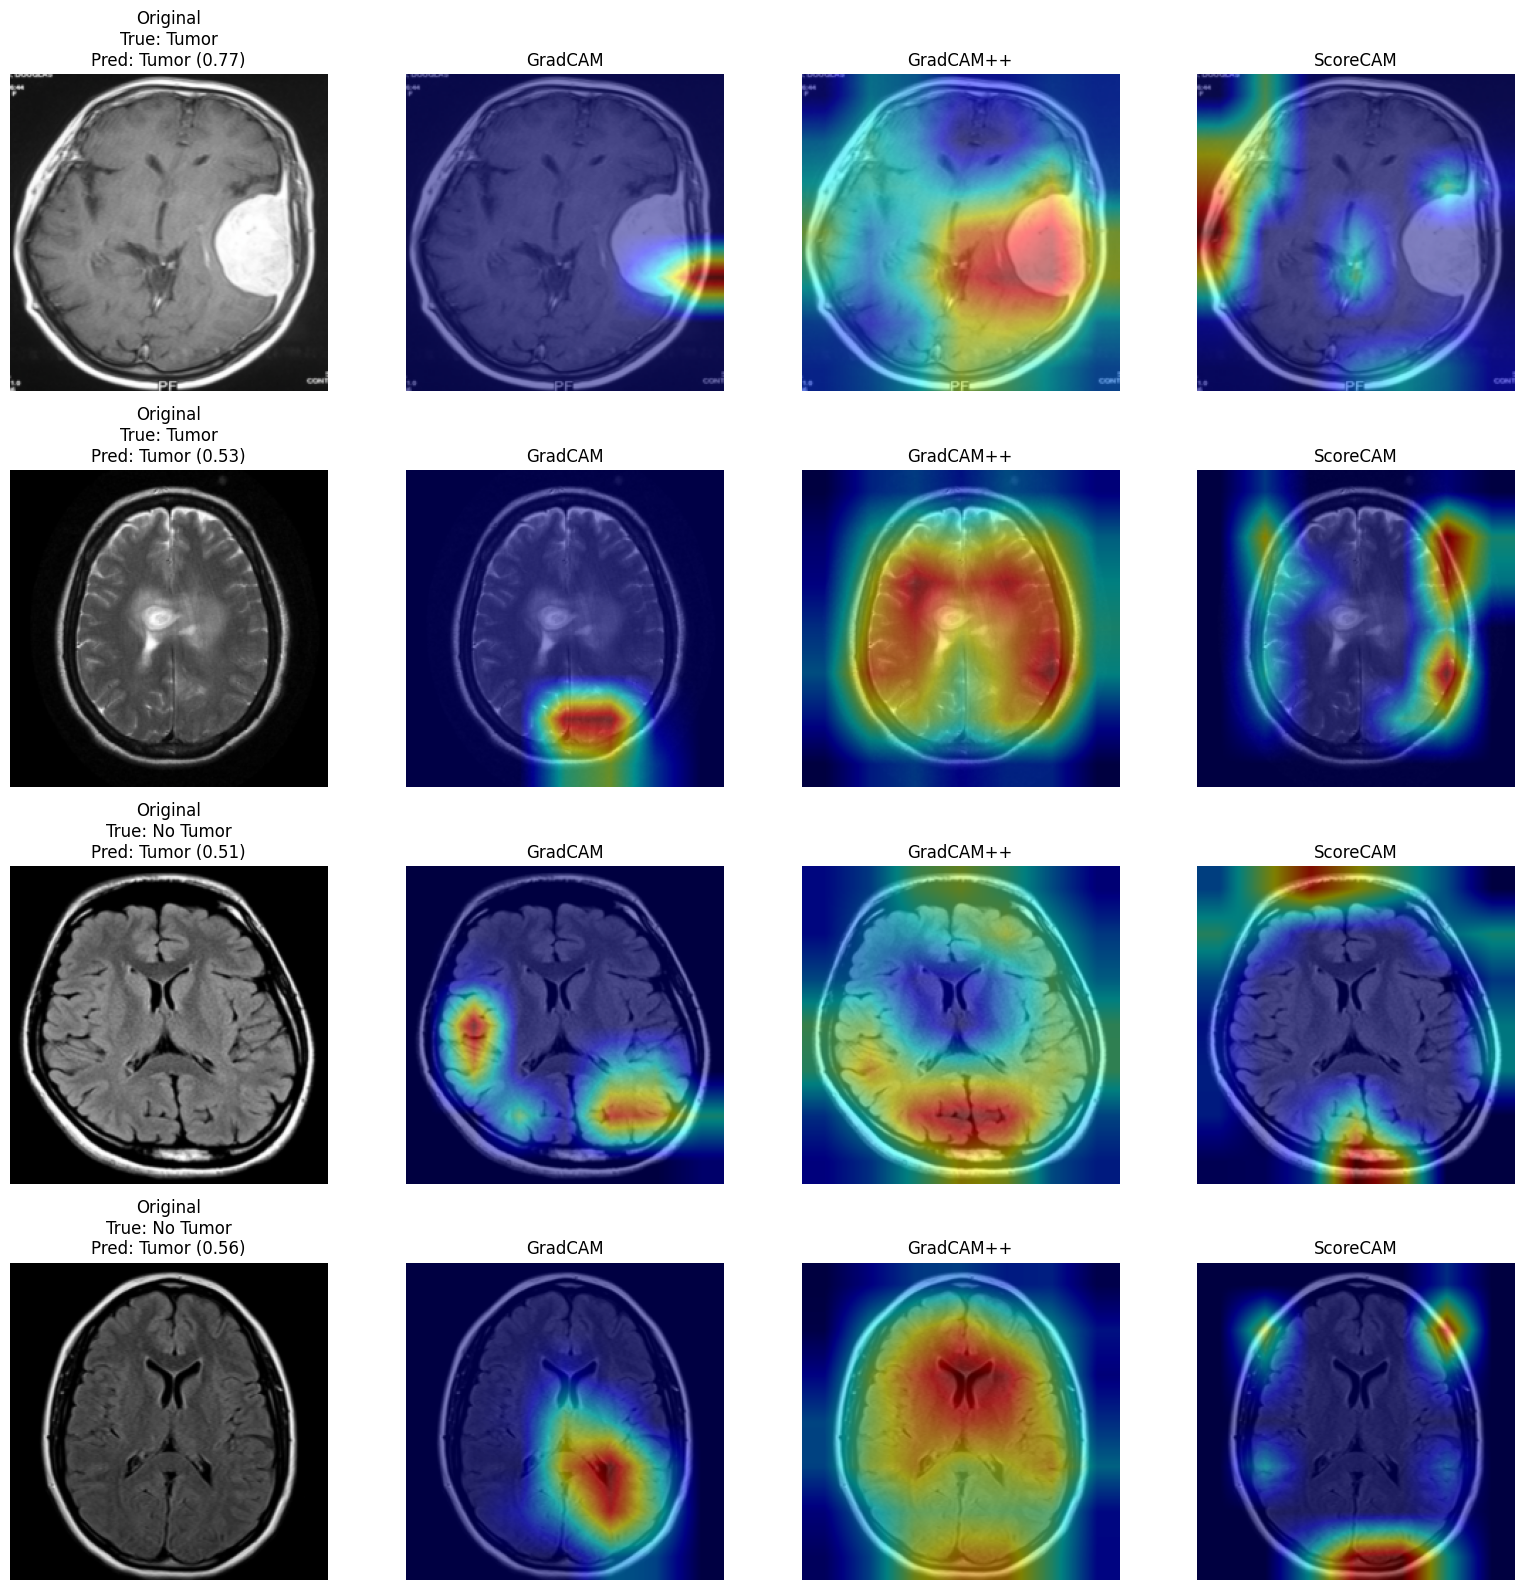

In [ ]:
# Let's visualize how the different CAM methods explain the model's predictions!
# We'll compare the original image with GradCAM, GradCAM++, and ScoreCAM.

# These are the standard mean and standard deviation values used to normalize ImageNet images.
# We're using them here to 'denormalize' our images back to a viewable state.
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def denormalize(tensor):
    """
    Takes a normalized PyTorch tensor (like our image data) and converts it
    back into a standard numpy array, ready for plotting.
    Essentially, it undoes the normalization so the image looks normal again.
    """
    img = tensor.cpu().numpy()
    img = img.transpose(1, 2, 0)  # Rearrange dimensions from Channel-Height-Width to Height-Width-Channel
    img = img * IMAGENET_STD + IMAGENET_MEAN # Scale it back up
    img = np.clip(img, 0, 1) # Make sure all pixel values are between 0 and 1
    return img

def show_xai_on_test(num_images=4):
    """
    Grabs a few images from our test set, runs them through the different
    CAM explanation methods, and then plots everything nicely side-by-side.
    It's super helpful for seeing what parts of an image influenced the model!
    """
    # Put the model in evaluation mode so it behaves consistently.
    model.eval()

    # Let's get just one batch of images and their true labels from our test data.
    # We'll only pick the first `num_images` from this batch.
    for images, labels in test_loader:
        images = images[:num_images]
        labels = labels[:num_images]
        break # We only need one batch to show our examples!

    # Convert our selected images to a tensor that our CAM methods can use.
    # Make sure it's on the same device (CPU/GPU) as our model!
    input_tensor = images.to(next(model.parameters()).device)

    # For our binary classifier, the CAM methods need to know which output
    # (or 'target') we're interested in explaining. Here, we're interested
    # in the 'tumor' probability, which corresponds to the 0th output.
    targets = [BinaryClassifierOutputTarget(0)] * input_tensor.size(0)

    # Time to compute the heatmaps using our different CAM techniques!
    # Each will return a grayscale heatmap for each image, showing importance.
    grayscale_cam_grad   = cam_grad(input_tensor=input_tensor, targets=targets)
    grayscale_cam_gradpp = cam_gradpp(input_tensor=input_tensor, targets=targets)
    grayscale_cam_score  = cam_score(input_tensor=input_tensor, targets=targets)

    # Set up our plotting area. We'll have a row for each image, and 4 columns
    # (Original, GradCAM, GradCAM++, ScoreCAM).
    plt.figure(figsize=(16, 4 * num_images))

    # We don't need to calculate gradients here, so let's save some computation.
    with torch.no_grad():
        # Let's also get the model's predicted probabilities for each image.
        # This will go into our plot titles for clarity.
        logits = model(input_tensor).view(-1)
        probs  = torch.sigmoid(logits).cpu().numpy()  # Get the actual tumor probabilities

    # Now, loop through each image and plot its explanations!
    for i in range(num_images):
        # First, get the original image back to its displayable form.
        img_denorm = denormalize(images[i])

        # Next, overlay the heatmaps from each CAM method onto the original image.
        # This creates those nice visual explanations.
        overlay_grad   = show_cam_on_image(img_denorm, grayscale_cam_grad[i],   use_rgb=True)
        overlay_gradpp = show_cam_on_image(img_denorm, grayscale_cam_gradpp[i], use_rgb=True)
        overlay_score  = show_cam_on_image(img_denorm, grayscale_cam_score[i],  use_rgb=True)

        # Grab the true label and the model's prediction for this image
        true_label = int(labels[i].item())
        true_text = "Tumor" if true_label == 1 else "No Tumor"
        prob_tumor = probs[i]
        pred_label = 1 if prob_tumor >= 0.5 else 0
        pred_text = "Tumor" if pred_label == 1 else "No Tumor"

        # This helps us arrange plots in rows.
        row = i * 4

        # --- Plot 1: The Original Image ---
        plt.subplot(num_images, 4, row + 1)
        plt.imshow(img_denorm)
        plt.title(f"Original Image\nTrue: {true_text}\nPred: {pred_text} (Prob: {prob_tumor:.2f})")
        plt.axis("off") # No axes needed for an image!

        # --- Plot 2: GradCAM Explanation ---
        plt.subplot(num_images, 4, row + 2)
        plt.imshow(overlay_grad)
        plt.title("GradCAM: Where model 'looked'")
        plt.axis("off")

        # --- Plot 3: GradCAM++ Explanation ---
        plt.subplot(num_images, 4, row + 3)
        plt.imshow(overlay_gradpp)
        plt.title("GradCAM++: More focused explanation")
        plt.axis("off")

        # --- Plot 4: ScoreCAM Explanation ---
        plt.subplot(num_images, 4, row + 4)
        plt.imshow(overlay_score)
        plt.title("ScoreCAM: Contextual importance")
        plt.axis("off")

    plt.tight_layout() # Adjust layout to prevent labels/titles from overlapping
    plt.show() # Show off our cool explanations!


# Let's run this function to see the explanations for a few test images!
show_xai_on_test(num_images=4)